In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


# CORAL-X

In [3]:
#Install Required Libraries
!pip install -q hvplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 3.4 MB/s eta 0:00:00a 0:00:01


In [2]:
#Required Imports
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [10]:
#Read the Data
# lending_club_loan_data=pd.read_csv('/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv')
data_path = '/Users/harshbhatt/Desktop/Northeastern/Sem 4/Capstone/data/accepted_2007_to_2018Q4.csv'
lending_club_loan_data=pd.read_csv(data_path)
lending_club_loan_data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,...,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.00,20000.00,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.00,35000.00,35000.00,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.00,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.00,10400.00,10400.00,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.00,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.00,40000.00,40000.00,60 months,10.49,859.56,B,B3,Vice President,9 years,MORTGAGE,227000.00,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,907xx,CA,12.75,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.00,24000.00,24000.00,60 months,14.49,564.56,C,C4,Program Manager,6 years,RENT,110000.00,Not Verified,Oct-2016,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,334xx,FL,18.30,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.00,44.82,1.00
2260698,88215728,NaN,14000.00,14000.00,14000.00,60 months,14.49,329.33,C,C4,Customer Service Technician,10+ years,MORTGAGE,95000.00,Verified,Oct-2016,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,NaN,770xx,TX,23.36,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
#Feature Selection relevant for our purpose
selected_features = [
    "loan_amnt", "term", "int_rate", "installment", "grade", "sub_grade", "emp_title",
    "emp_length", "home_ownership", "annual_inc", "verification_status", "issue_d",
    "loan_status", "purpose", "title", "zip_code", "addr_state", "dti", "earliest_cr_line",
    "open_acc", "pub_rec", "revol_bal", "revol_util", "total_acc", "initial_list_status",
    "application_type", "mort_acc", "pub_rec_bankruptcies"
]

#Filtering the DataFrame to keep only the required columns
lending_club_loan_data_filtered = lending_club_loan_data[selected_features]

#Display the first few rows to verify
lending_club_loan_data_filtered.shape

(2260701, 28)

In [12]:
lending_club_loan_data_filtered.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,Fully Paid,debt_consolidation,Debt consolidation,190xx,PA,5.91,Aug-2003,7.00,0.00,2765.00,29.70,13.00,w,Individual,1.00,0.00
1,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,Fully Paid,small_business,Business,577xx,SD,16.06,Dec-1999,22.00,0.00,21470.00,19.20,38.00,w,Individual,4.00,0.00
2,20000.00,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.00,Not Verified,Dec-2015,Fully Paid,home_improvement,NaN,605xx,IL,10.78,Aug-2000,6.00,0.00,7869.00,56.20,18.00,w,Joint App,5.00,0.00
3,35000.00,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.00,Source Verified,Dec-2015,Current,debt_consolidation,Debt consolidation,076xx,NJ,17.06,Sep-2008,13.00,0.00,7802.00,11.60,17.00,w,Individual,1.00,0.00
4,10400.00,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.00,Source Verified,Dec-2015,Fully Paid,major_purchase,Major purchase,174xx,PA,25.37,Jun-1998,12.00,0.00,21929.00,64.50,35.00,w,Individual,6.00,0.00


## Data Description

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Feature</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>loan_amnt</td>
      <td>The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.</td>
    </tr>
    <tr>
      <th>1</th>
      <td>term</td>
      <td>The number of payments on the loan. Values are in months and can be either 36 or 60.</td>
    </tr>
    <tr>
      <th>2</th>
      <td>int_rate</td>
      <td>Interest Rate on the loan</td>
    </tr>
    <tr>
      <th>3</th>
      <td>installment</td>
      <td>The monthly payment owed by the borrower if the loan originates.</td>
    </tr>
    <tr>
      <th>4</th>
      <td>grade</td>
      <td>LC assigned loan grade</td>
    </tr>
    <tr>
      <th>5</th>
      <td>sub_grade</td>
      <td>LC assigned loan subgrade</td>
    </tr>
    <tr>
      <th>6</th>
      <td>emp_title</td>
      <td>The job title supplied by the Borrower when applying for the loan.*</td>
    </tr>
    <tr>
      <th>7</th>
      <td>emp_length</td>
      <td>Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.</td>
    </tr>
    <tr>
      <th>8</th>
      <td>home_ownership</td>
      <td>The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER</td>
    </tr>
    <tr>
      <th>9</th>
      <td>annual_inc</td>
      <td>The self-reported annual income provided by the borrower during registration.</td>
    </tr>
    <tr>
      <th>10</th>
      <td>verification_status</td>
      <td>Indicates if income was verified by LC, not verified, or if the income source was verified</td>
    </tr>
    <tr>
      <th>11</th>
      <td>issue_d</td>
      <td>The month which the loan was funded</td>
    </tr>
    <tr>
      <th>12</th>
      <td>loan_status</td>
      <td>Current status of the loan</td>
    </tr>
    <tr>
      <th>13</th>
      <td>purpose</td>
      <td>A category provided by the borrower for the loan request.</td>
    </tr>
    <tr>
      <th>14</th>
      <td>title</td>
      <td>The loan title provided by the borrower</td>
    </tr>
    <tr>
      <th>15</th>
      <td>zip_code</td>
      <td>The first 3 numbers of the zip code provided by the borrower in the loan application.</td>
    </tr>
    <tr>
      <th>16</th>
      <td>addr_state</td>
      <td>The state provided by the borrower in the loan application</td>
    </tr>
    <tr>
      <th>17</th>
      <td>dti</td>
      <td>A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.</td>
    </tr>
    <tr>
      <th>18</th>
      <td>earliest_cr_line</td>
      <td>The month the borrower's earliest reported credit line was opened</td>
    </tr>
    <tr>
      <th>19</th>
      <td>open_acc</td>
      <td>The number of open credit lines in the borrower's credit file.</td>
    </tr>
    <tr>
      <th>20</th>
      <td>pub_rec</td>
      <td>Number of derogatory public records</td>
    </tr>
    <tr>
      <th>21</th>
      <td>revol_bal</td>
      <td>Total credit revolving balance</td>
    </tr>
    <tr>
      <th>22</th>
      <td>revol_util</td>
      <td>Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.</td>
    </tr>
    <tr>
      <th>23</th>
      <td>total_acc</td>
      <td>The total number of credit lines currently in the borrower's credit file</td>
    </tr>
    <tr>
      <th>24</th>
      <td>initial_list_status</td>
      <td>The initial listing status of the loan. Possible values are – W, F</td>
    </tr>
    <tr>
      <th>25</th>
      <td>application_type</td>
      <td>Indicates whether the loan is an individual application or a joint application with two co-borrowers</td>
    </tr>
    <tr>
      <th>26</th>
      <td>mort_acc</td>
      <td>Number of mortgage accounts.</td>
    </tr>
    <tr>
      <th>27</th>
      <td>pub_rec_bankruptcies</td>
      <td>Number of public record bankruptcies</td>
    </tr>
  </tbody>
</table>

## Exploratory Data Analysis

In [13]:
#Unique categories of loan status
lending_club_loan_data['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [14]:
#Mapping loan statuses to 'Fully Paid' and 'Charged Off'
status_mapping = {
    'Fully Paid': 'Fully Paid',
    'Current': 'Fully Paid',
    'In Grace Period': 'Fully Paid',
    'Charged Off': 'Charged Off',
    'Late (31-120 days)': 'Charged Off',
    'Late (16-30 days)': 'Charged Off'
}

#Apply the mapping to the 'loan_status' column
lending_club_loan_data_filtered['loan_status'] = lending_club_loan_data_filtered['loan_status'].replace(status_mapping)
lending_club_loan_data_filtered['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
#We are filtering only Fully Paid and Charged Off loans as those are relevant to this problem statement
lending_club_loan_data_target_filtered = lending_club_loan_data_filtered[lending_club_loan_data_filtered['loan_status'].isin(['Fully Paid', 'Current', 'In Grace Period', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)'])]
lending_club_loan_data_target_filtered.shape

(2257879, 28)

In [16]:
#Info about the data
lending_club_loan_data_target_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2257879 entries, 0 to 2260698
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   loan_amnt             float64
 1   term                  object 
 2   int_rate              float64
 3   installment           float64
 4   grade                 object 
 5   sub_grade             object 
 6   emp_title             object 
 7   emp_length            object 
 8   home_ownership        object 
 9   annual_inc            float64
 10  verification_status   object 
 11  issue_d               object 
 12  loan_status           object 
 13  purpose               object 
 14  title                 object 
 15  zip_code              object 
 16  addr_state            object 
 17  dti                   float64
 18  earliest_cr_line      object 
 19  open_acc              float64
 20  pub_rec               float64
 21  revol_bal             float64
 22  revol_util            float64
 23  total_acc   

In [17]:
#Data Statistics
lending_club_loan_data_target_filtered.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,2257879.00,2257879.00,2257879.00,2257879.00,2256168.00,2257879.00,2257879.00,2257879.00,2256117.00,2257879.00,2210598.00,2257182.00
mean,15054.26,13.09,445.99,78000.49,18.83,11.61,0.20,16645.47,50.33,24.16,1.56,0.13
std,9190.85,4.83,267.18,112739.70,14.19,5.64,0.57,22862.08,24.71,11.98,1.90,0.36
min,500.00,5.31,4.93,0.00,-1.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00
25%,8000.00,9.49,251.77,46000.00,11.90,8.00,0.00,5954.50,31.50,15.00,0.00,0.00
50%,12950.00,12.62,378.20,65000.00,17.84,11.00,0.00,11327.00,50.30,22.00,1.00,0.00
75%,20000.00,15.99,593.49,93000.00,24.50,14.00,0.00,20245.00,69.30,31.00,3.00,0.00
max,40000.00,30.99,1719.83,110000000.00,999.00,101.00,86.00,2904836.00,892.30,176.00,94.00,12.00


### Univariate EDA

In [18]:
#Distribution of Loan Status (Target)
lending_club_loan_data_target_filtered['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)

:Bars   [loan_status]   (count)

In [19]:
#Classify columns
numerical_cols = lending_club_loan_data_target_filtered.select_dtypes(include=['number']).columns.tolist()
categorical_cols = lending_club_loan_data_target_filtered.select_dtypes(exclude=['number']).columns.tolist()

#Remove Target
categorical_cols.remove('loan_status')

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
Categorical Columns: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']


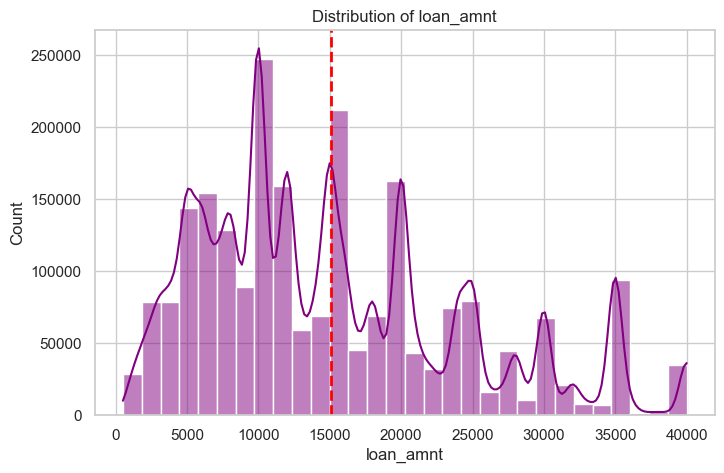

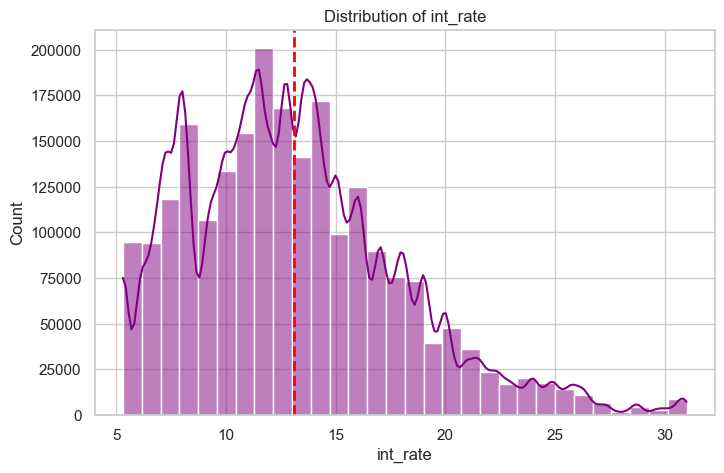

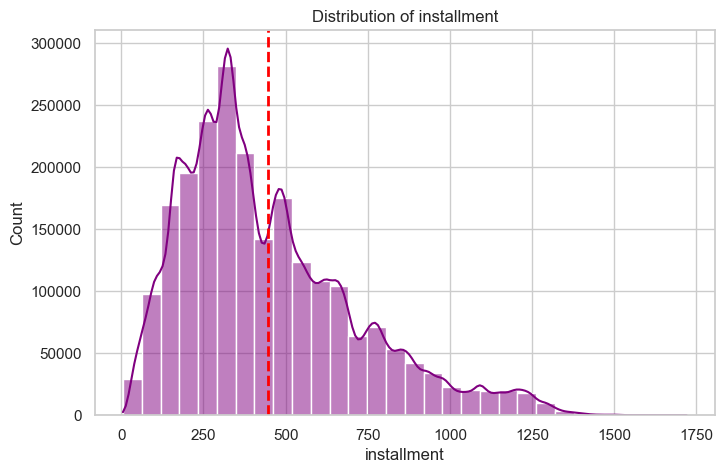

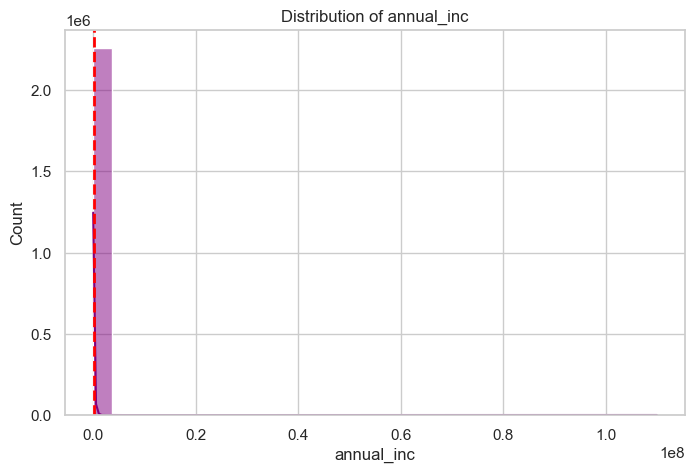

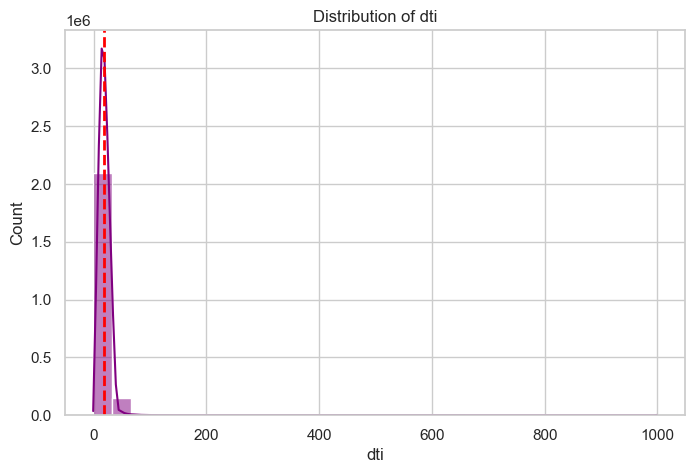

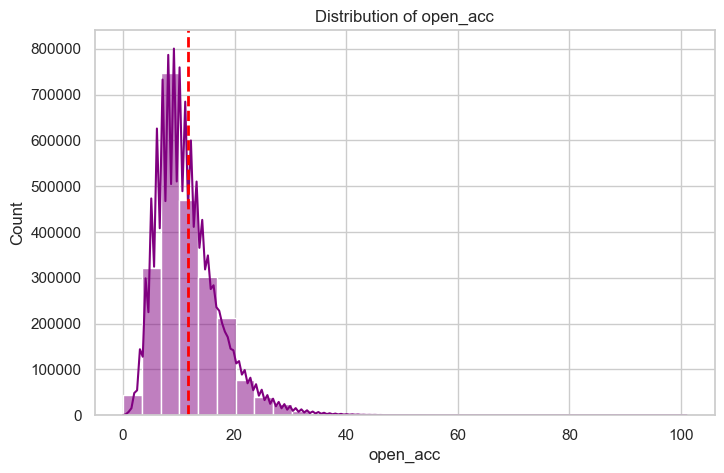

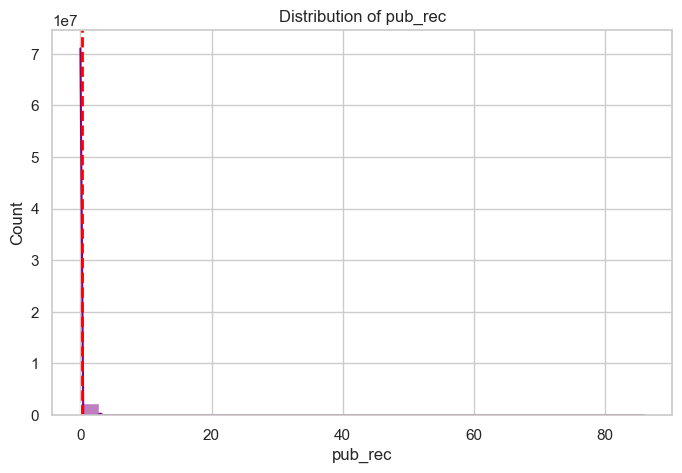

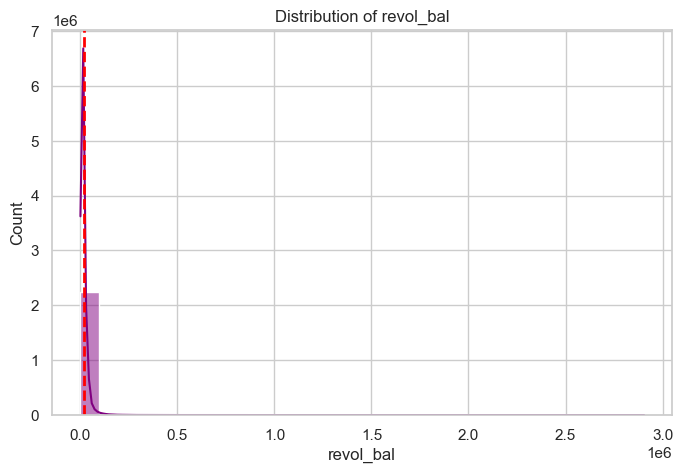

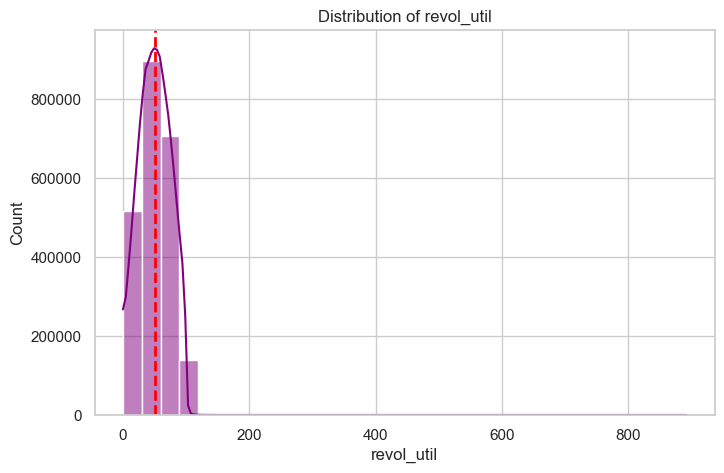

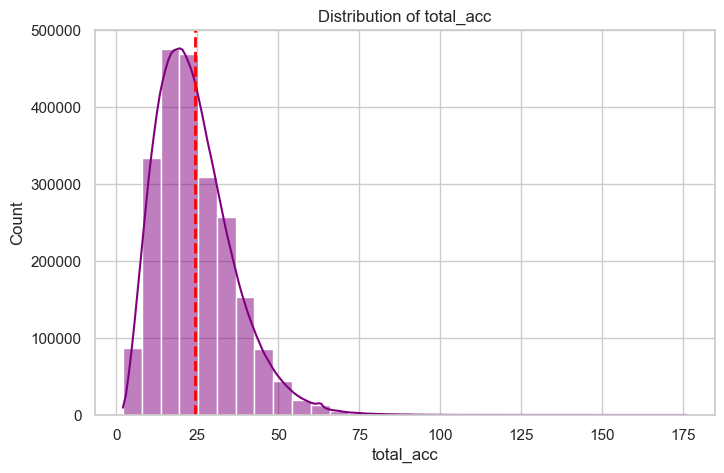

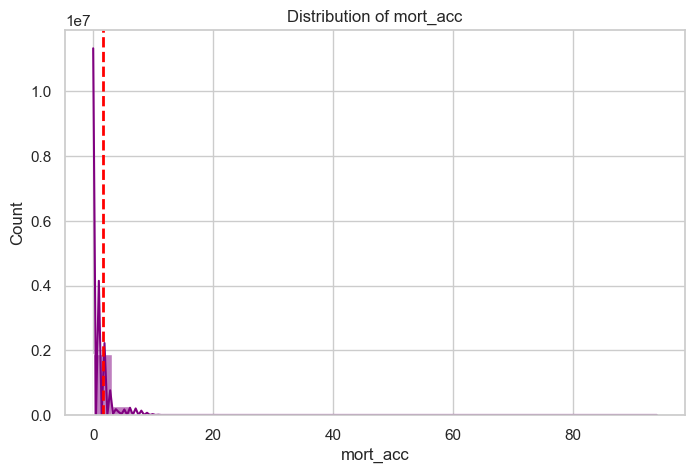

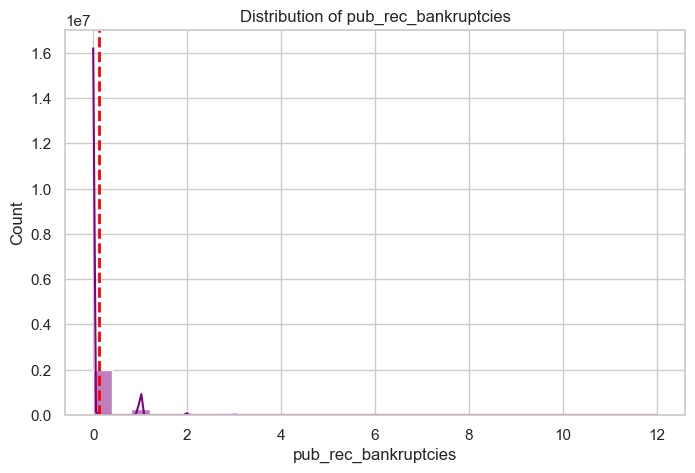

In [20]:
#Univariate EDA - Numerical Columns
sns.set(style="whitegrid", palette="viridis")

#Plot Numerical Columns - Histograms
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(lending_club_loan_data_target_filtered[col], kde=True, bins=30, color='purple')
    plt.axvline(lending_club_loan_data_target_filtered[col].mean(), color='red', linestyle='dashed', linewidth=2)  # Mean line
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.show()

In [21]:
lending_club_loan_data_target_filtered.shape

(2257879, 28)

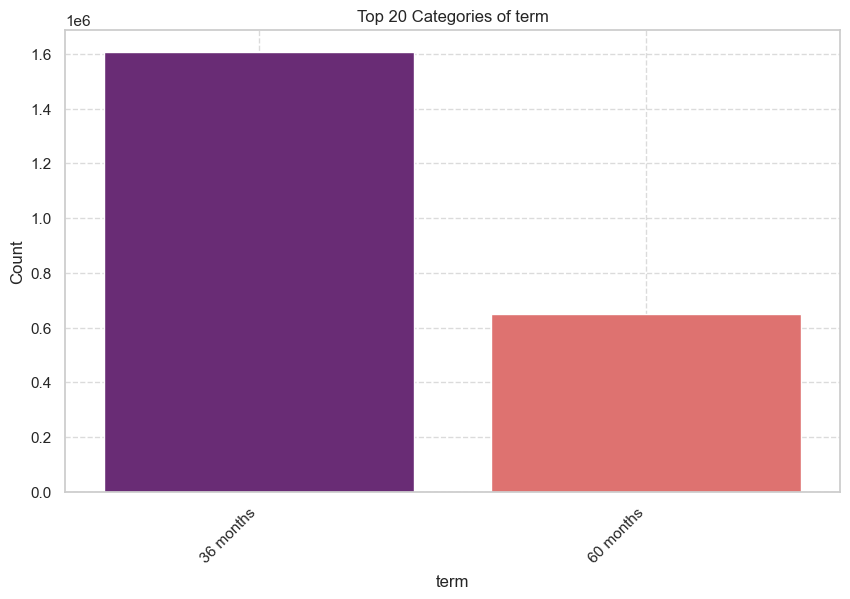

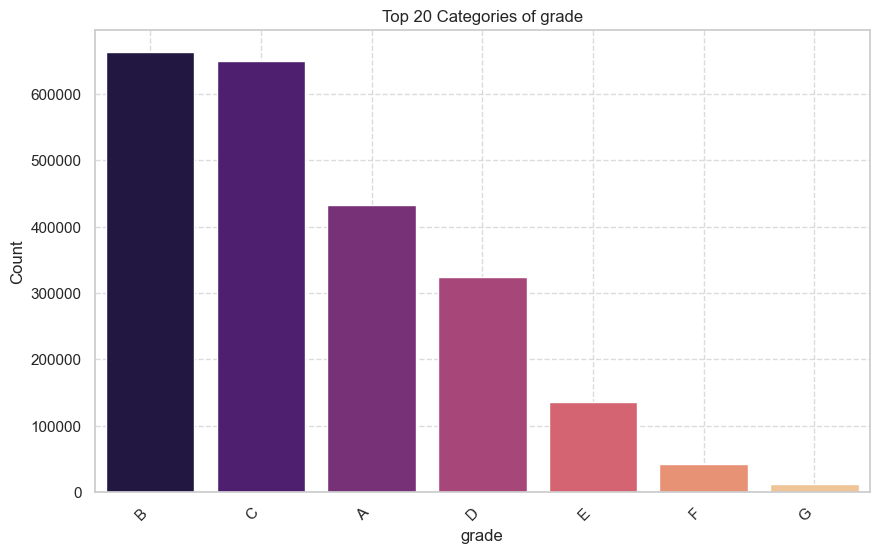

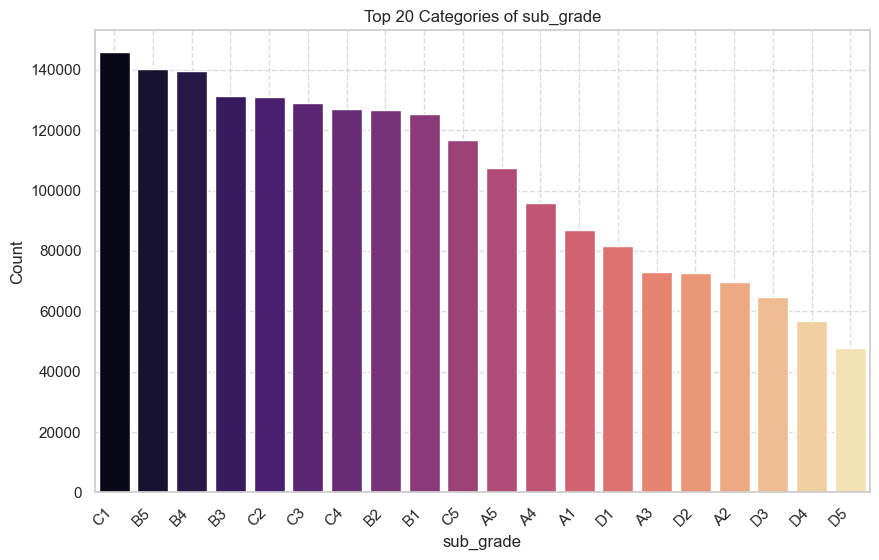

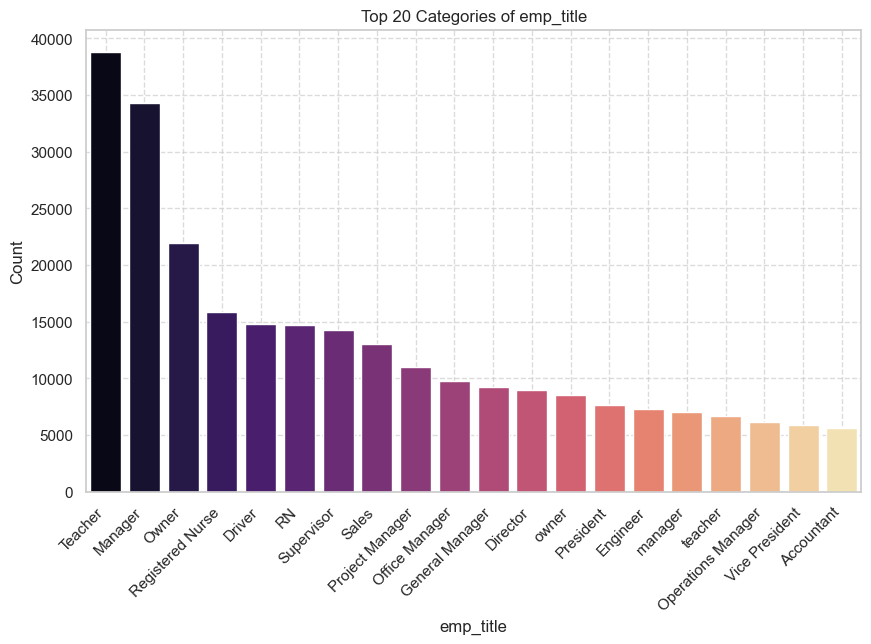

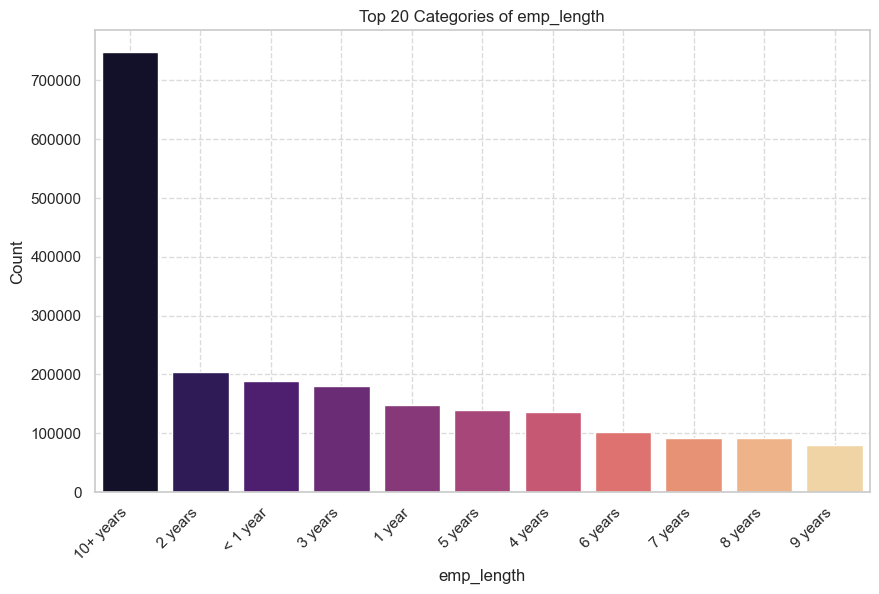

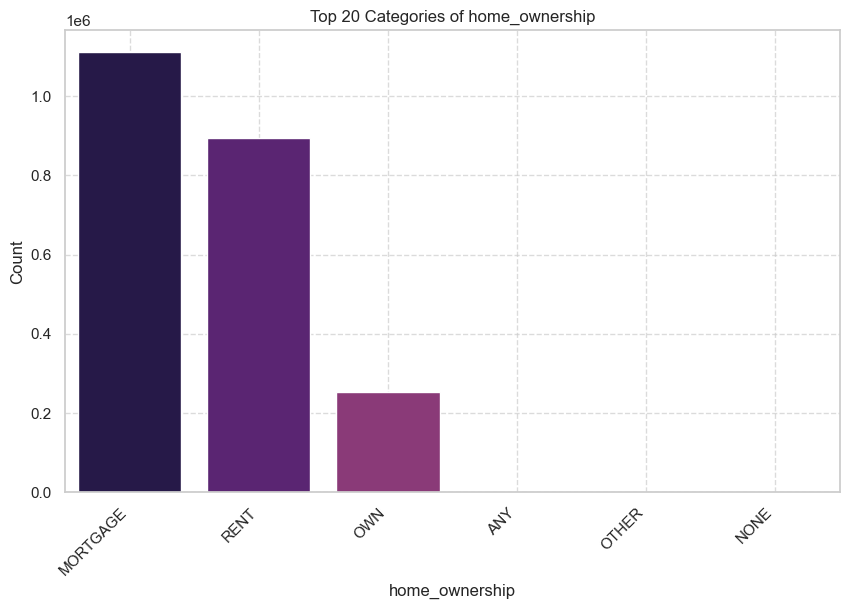

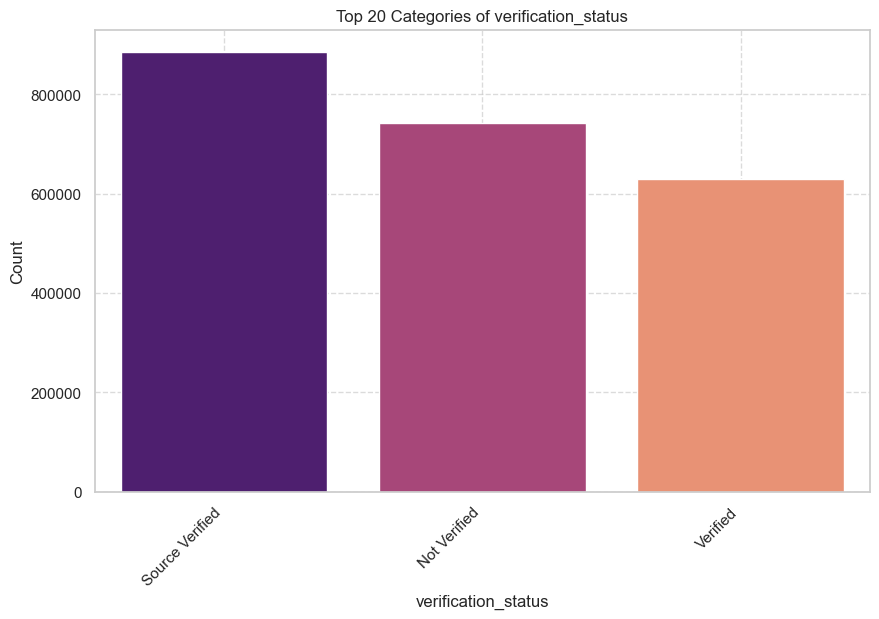

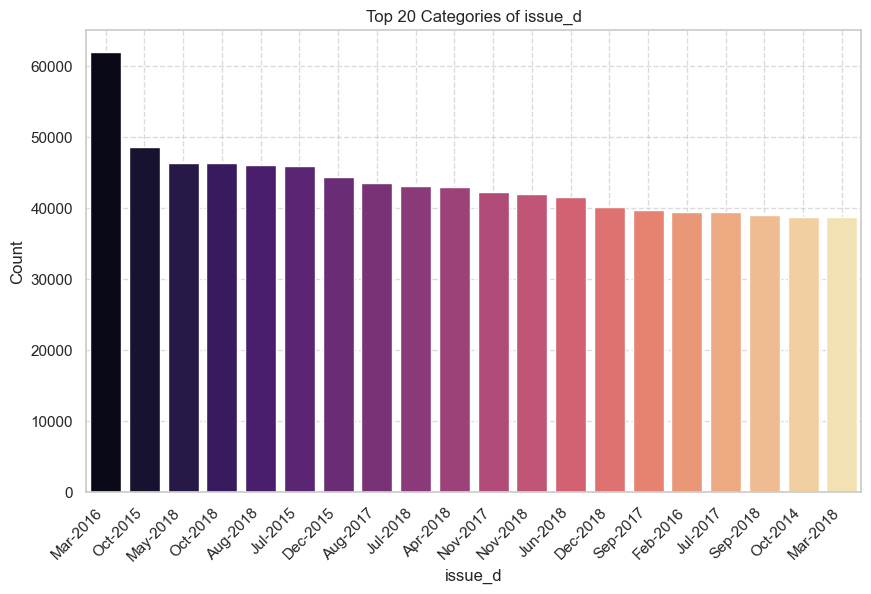

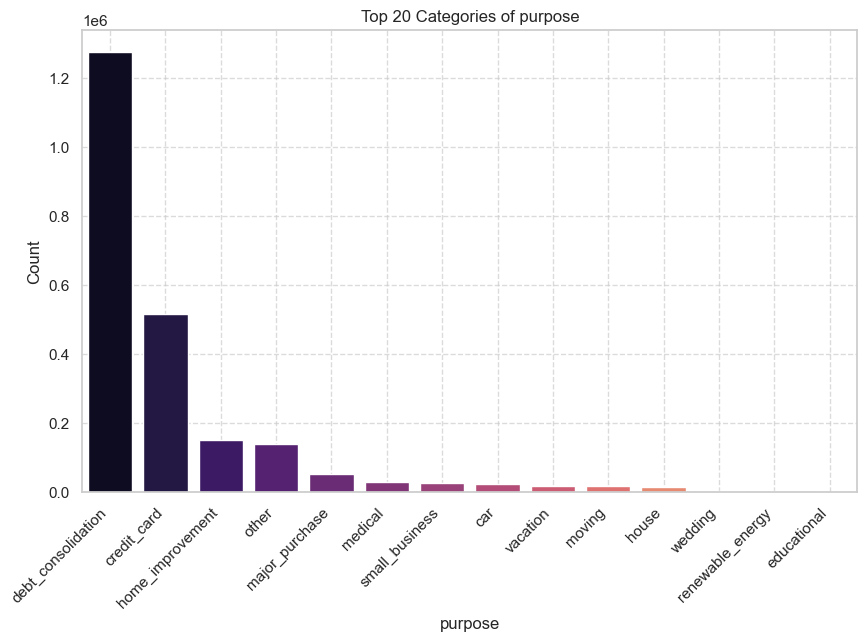

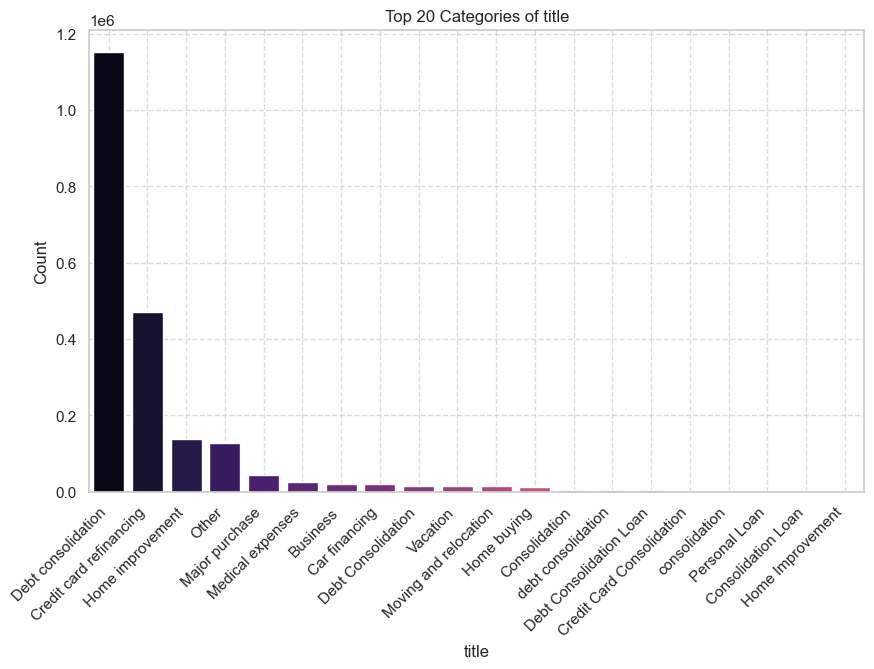

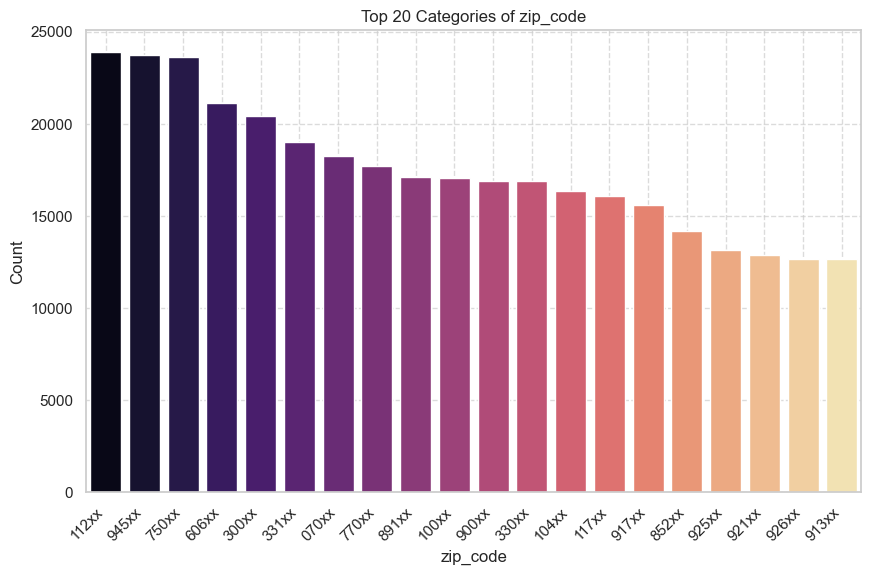

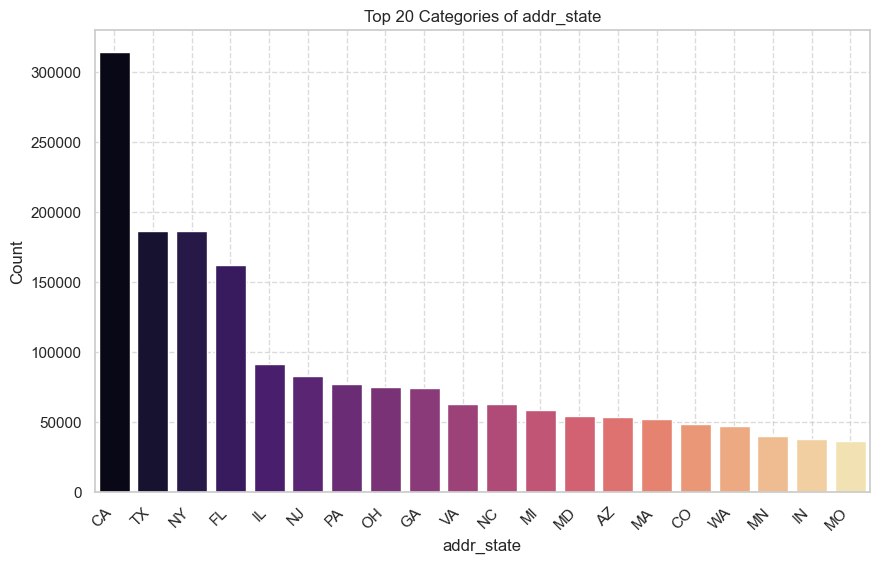

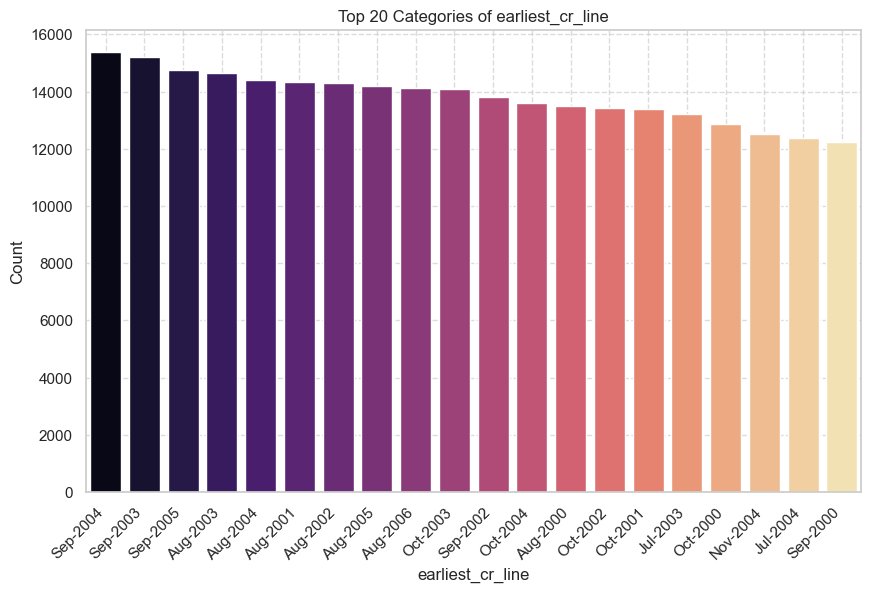

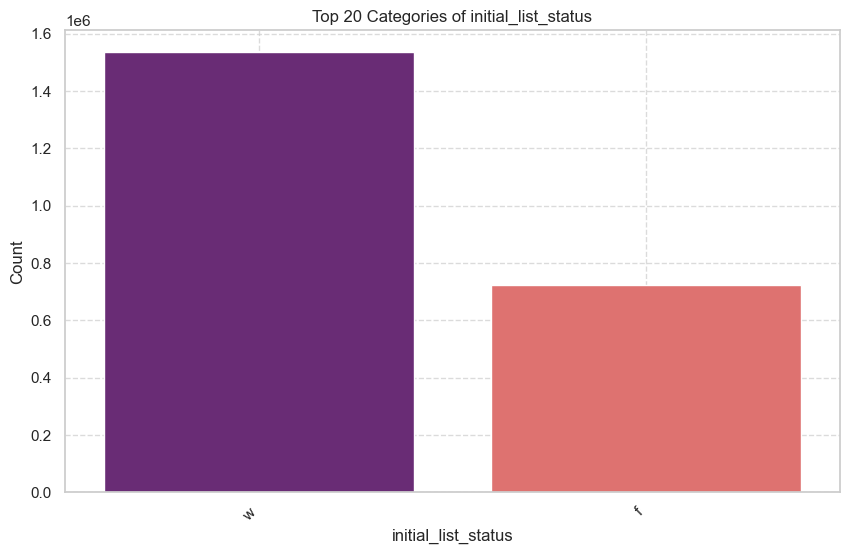

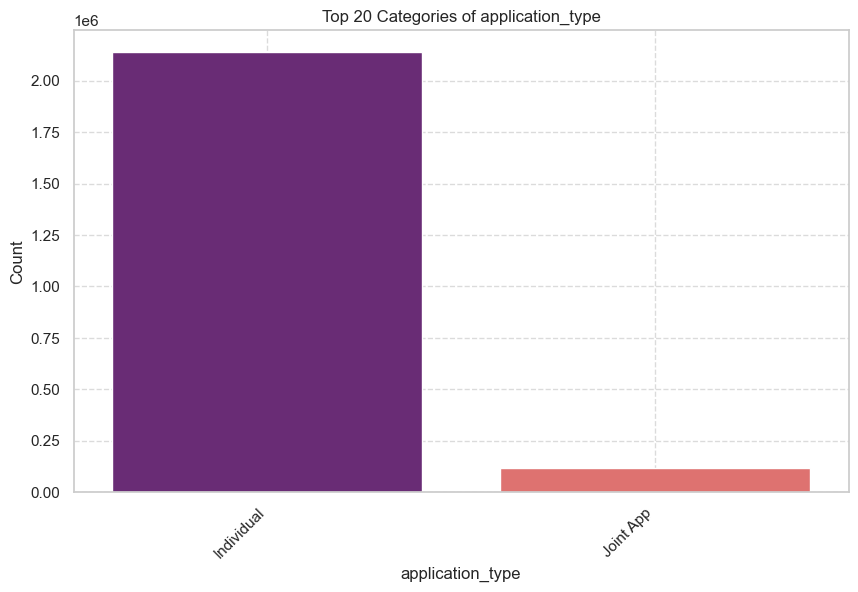

In [22]:
#Univariate EDA - Categorical Columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    value_counts = lending_club_loan_data_target_filtered[col].value_counts().sort_values(ascending=False)
    if len(value_counts) > 20: 
        value_counts = value_counts[:20]
    
    sns.barplot(x=value_counts.index, y=value_counts.values, palette="magma")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Top 20 Categories of {col}")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

### Correlation Heatmap

<Axes: >

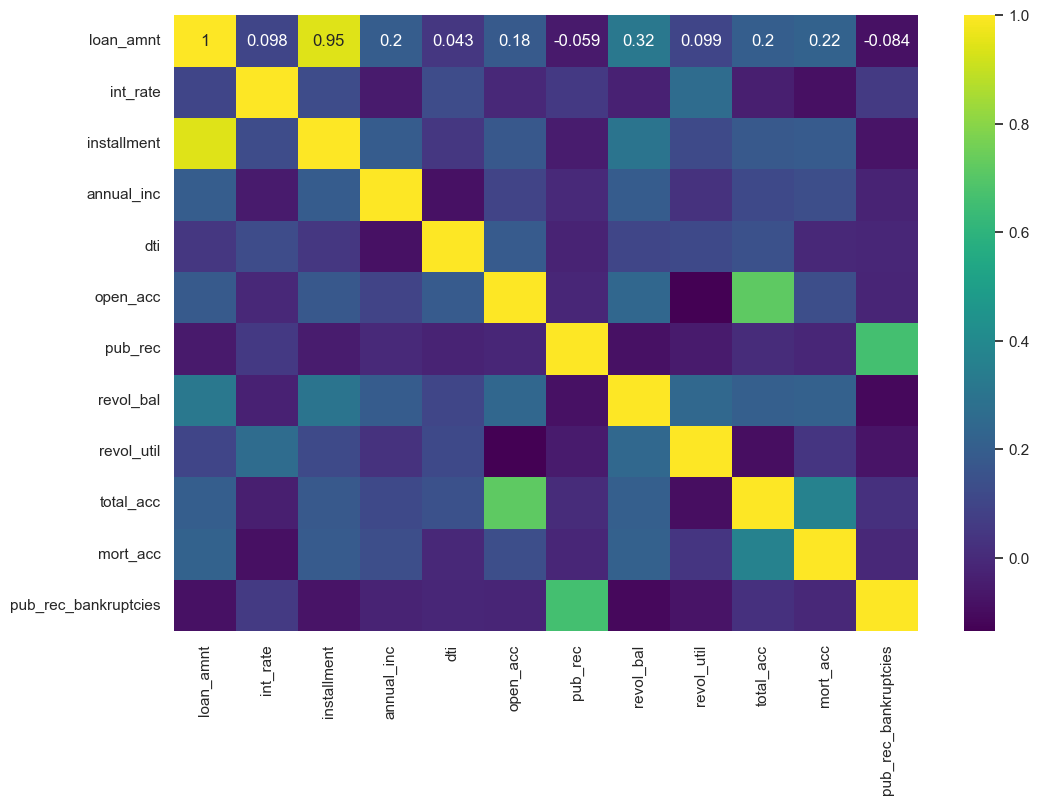

In [23]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lending_club_loan_data_target_filtered[numerical_cols].corr(), annot=True, cmap='viridis')

The heatmap shows a strong positive correlation (0.95) between `loan_amnt` and `installment`, indicating that higher loan amounts lead to higher monthly payments. This is expected as installment calculations depend primarily on loan amount, term, and interest rate. However, the lower correlation (0.12) between `installment` and `int_rate` suggests loan amount has a greater influence. Given the near-perfect correlation, one of these features may be redundant in predictive modeling, requiring careful feature selection to avoid multicollinearity.

### Distribution of Key Features by Loan Status (Target)


In [24]:
installment = lending_club_loan_data_target_filtered.hvplot.hist(
    y='installment', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Installment by Loan Status", 
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = lending_club_loan_data_target_filtered.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False, 
    width=350, height=400, bins=30, alpha=0.4, 
    title="Loan Amount by Loan Status", 
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (installment_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (loan_amnt_count)

In [25]:
#Grade
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'grade'
].value_counts().hvplot.bar(label="Fully Paid", color="navy")

charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'grade'
].value_counts().hvplot.bar(label="Charged Off", color="red")

grades = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=450, legend_position='top_right', 
    shared_axes=False
)

#Sub_grade
fully_paid_sub = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'sub_grade'
].value_counts().hvplot.bar(label="Fully Paid", color="navy")

charged_off_sub = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'sub_grade'
].value_counts().hvplot.bar(label="Charged Off", color="red")

sub_grades = (fully_paid_sub * charged_off_sub).opts(
    title="Loan Status by Sub Grade", xlabel='Sub Grades', ylabel='Count',
    width=500, height=450, legend_position='top_right', 
    shared_axes=False
)

grades + sub_grades

:Layout
   .Overlay.I  :Overlay
      .Bars.Fully_Paid  :Bars   [grade]   (count)
      .Bars.Charged_Off :Bars   [grade]   (count)
   .Overlay.II :Overlay
      .Bars.Fully_Paid  :Bars   [sub_grade]   (count)
      .Bars.Charged_Off :Bars   [sub_grade]   (count)

In [26]:
#Generate bar plot for homeownership distribution for Fully Paid loans
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'home_ownership'
].value_counts().hvplot.bar(label="Fully Paid", color="navy")

#Generate bar plot for homeownership distribution for Charged Off loans
charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'home_ownership'
].value_counts().hvplot.bar(label="Charged Off", color="red")

#Overlay both distributions for comparison
home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Home Ownership", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_position='top_right'
).opts(xrotation=90)  # Ensure category labels are readable

home_ownership_count

:Overlay
   .Bars.Fully_Paid  :Bars   [home_ownership]   (count)
   .Bars.Charged_Off :Bars   [home_ownership]   (count)

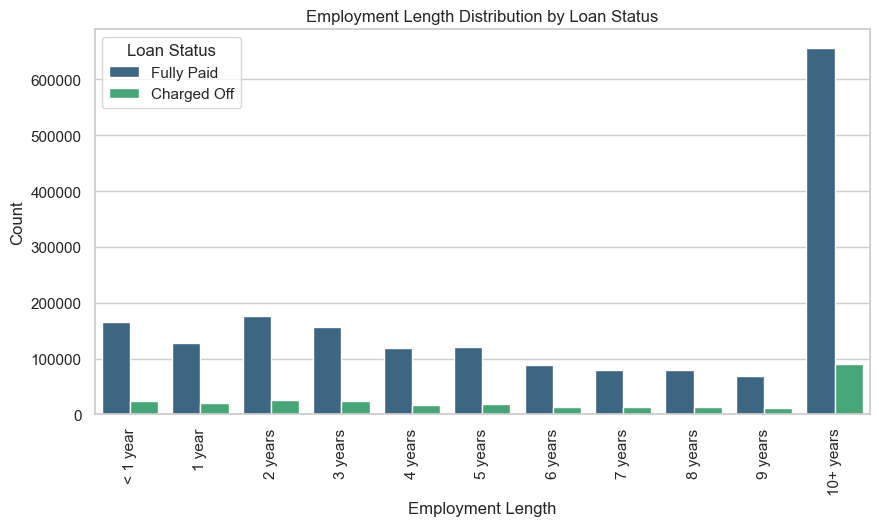

In [27]:
plt.figure(figsize=(10, 5))

#Employment Length Distribution
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years']
g = sns.countplot(x='emp_length', data=lending_club_loan_data_target_filtered, hue='loan_status', 
                  order=order, palette="viridis")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Employment Length Distribution by Loan Status")
plt.xlabel("Employment Length")
plt.ylabel("Count")
plt.legend(title="Loan Status")

In [28]:
#Convert to Date format
lending_club_loan_data_target_filtered['issue_d'] = pd.to_datetime(lending_club_loan_data_target_filtered['issue_d'])
lending_club_loan_data_target_filtered['earliest_cr_line'] = pd.to_datetime(lending_club_loan_data_target_filtered['earliest_cr_line'])

In [29]:
#Generate histogram for loan issue dates categorized by Fully Paid loans
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'issue_d'
].hvplot.hist(bins=35, label="Fully Paid", color="navy")

#Generate histogram for loan issue dates categorized by Charged Off loans
charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'issue_d'
].hvplot.hist(bins=35, label="Charged Off", color="red")

loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_position='top_right'
).opts(xrotation=45)  

loan_issue_date

:Overlay
   .Histogram.I  :Histogram   [issue_d]   (issue_d_count)
   .Histogram.II :Histogram   [issue_d]   (issue_d_count)

In [30]:
#Generate histogram for earliest credit line distribution categorized by Fully Paid loans
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'earliest_cr_line'
].hvplot.hist(bins=35, label="Fully Paid", color="green")

#Generate histogram for earliest credit line distribution categorized by Charged Off loans
charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'earliest_cr_line'
].hvplot.hist(bins=35, label="Charged Off", color="red")

#Overlay both distributions for trend analysis
earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by Earliest Credit Line", xlabel='Earliest Credit Line', ylabel='Count',
    width=350, height=350, legend_position='top_right'
).opts(xrotation=45)

earliest_cr_line

:Overlay
   .Histogram.I  :Histogram   [earliest_cr_line]   (earliest_cr_line_count)
   .Histogram.II :Histogram   [earliest_cr_line]   (earliest_cr_line_count)

In [31]:
dti = lending_club_loan_data_target_filtered[lending_club_loan_data_target_filtered['dti']<=50].hvplot.hist(
    y='dti', by='loan_status', bins=50, width=500, height=350, 
    title="Loan Status by dti (<=50) Distribution", xlabel='dti', ylabel='Count', 
    alpha=0.3, legend='top'
)

dti

:NdOverlay   [loan_status]
   :Histogram   [dti]   (dti_count)

In [32]:
title="Loan Status by The number of open credit lines"

open_acc = lending_club_loan_data_target_filtered.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, width=500, height=350, 
    title=title, xlabel='The number of open credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

open_acc

:NdOverlay   [loan_status]
   :Histogram   [open_acc]   (open_acc_count)

In [33]:
title="Loan Status by The total number of credit lines"

total_acc = lending_club_loan_data_target_filtered.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, width=500, height=400, 
    title=title, xlabel='The total number of credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

total_acc

:NdOverlay   [loan_status]
   :Histogram   [total_acc]   (total_acc_count)

In [34]:
title="Loan Status by Revolving line utilization rate"

revol_util = lending_club_loan_data_target_filtered.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=500, height=500, 
    title=title, xlabel='Revolving line utilization rate', ylabel='Count', 
    alpha=0.4, legend='top'
)

revol_util 

:NdOverlay   [loan_status]
   :Histogram   [revol_util]   (revol_util_count)

In [35]:
title = "Loan Status by Total credit revolving balance"

revol_bal = lending_club_loan_data_target_filtered.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=600, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = lending_club_loan_data_target_filtered[lending_club_loan_data_target_filtered['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=600, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)


revol_bal + sub_revol_bal

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (revol_bal_count)

In [36]:
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'pub_rec'
].value_counts().hvplot.bar(label="Fully Paid", color="navy")

charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'pub_rec'
].value_counts().hvplot.bar(label="Charged Off", color="red")

pub_rec_plot = (fully_paid * charged_off).opts(
    title="Loan Status by Number of Derogatory Public Records",
    xlabel="Number of Derogatory Public Records", ylabel="Count",
    width=500, height=400, legend_position='top_right', show_legend=True
)

pub_rec_plot

:Overlay
   .Bars.Fully_Paid  :Bars   [pub_rec]   (count)
   .Bars.Charged_Off :Bars   [pub_rec]   (count)

In [37]:
fully_paid = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'initial_list_status'
].value_counts().hvplot.bar(label="Fully Paid", color="navy")

charged_off = lending_club_loan_data_target_filtered.loc[
    lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'initial_list_status'
].value_counts().hvplot.bar(label="Charged Off", color="red")

initial_list_status_plot = (fully_paid * charged_off).opts(
    title="Loan Status by The Initial Listing Status of the Loan",
    xlabel="The Initial Listing Status of the Loan", ylabel="Count",
    width=500, height=400, legend_position='top_right', show_legend=True
)

initial_list_status_plot

:Overlay
   .Bars.Fully_Paid  :Bars   [initial_list_status]   (count)
   .Bars.Charged_Off :Bars   [initial_list_status]   (count)

In [38]:
fully_paid = lending_club_loan_data_target_filtered.loc[lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'application_type'].value_counts().hvplot.bar(
    label="Fully Paid", color="navy")

charged_off = lending_club_loan_data_target_filtered.loc[lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'application_type'].value_counts().hvplot.bar(
    label="Charged Off", color="red")

application_type_plot = (fully_paid * charged_off).opts(
    title="Loan Status by Application Type",
    xlabel="Application Type",
    ylabel="Count",
    width=500, height=400,
    legend_position='top_right',
    show_legend=True
)

application_type_plot

:Overlay
   .Bars.Fully_Paid  :Bars   [application_type]   (count)
   .Bars.Charged_Off :Bars   [application_type]   (count)

In [39]:
fully_paid = lending_club_loan_data_target_filtered.loc[lending_club_loan_data_target_filtered['loan_status'] == 'Fully Paid', 'pub_rec_bankruptcies'].value_counts().hvplot.bar(
    label="Fully Paid", color="navy"
)

charged_off = lending_club_loan_data_target_filtered.loc[lending_club_loan_data_target_filtered['loan_status'] == 'Charged Off', 'pub_rec_bankruptcies'].value_counts().hvplot.bar(
    label="Charged Off", color="red"
)

bankruptcies_plot = (fully_paid * charged_off).opts(
    title="Loan Status by Number of Public Record Bankruptcies",
    xlabel="Number of Public Record Bankruptcies",
    ylabel="Count",
    width=500, height=400,
    legend_position='top_right',
    show_legend=True
)

bankruptcies_plot

:Overlay
   .Bars.Fully_Paid  :Bars   [pub_rec_bankruptcies]   (count)
   .Bars.Charged_Off :Bars   [pub_rec_bankruptcies]   (count)

### Bivariate EDA

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd

roc_auc_scores_numerical = {}

#Iterate through numerical columns and evaluate their predictive power
for col in numerical_cols:
    #Prepare feature matrix and target variable
    X = lending_club_loan_data_target_filtered[[col]]
    y = lending_club_loan_data_target_filtered['loan_status']

    #Handle missing values using median imputation
    imputer = SimpleImputer(strategy="median")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_imputed, y_train)

    y_pred_proba = model.predict_proba(X_test_imputed)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores_numerical[col] = roc_auc

#Convert results into a DataFrame and sort by ROC AUC score
roc_auc_numerical_df = pd.DataFrame(roc_auc_scores_numerical.items(), columns=['Feature', 'ROC AUC Score']).sort_values(by="ROC AUC Score", ascending=False)
roc_auc_numerical_df

,Feature,ROC AUC Score
1,int_rate,0.73
2,installment,0.65
0,loan_amnt,0.58
8,revol_util,0.55
4,dti,0.55
3,annual_inc,0.54
10,mort_acc,0.53
6,pub_rec,0.52
5,open_acc,0.52
11,pub_rec_bankruptcies,0.51


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

roc_auc_scores_categorical = {}

#Iterate through categorical columns and evaluate their predictive power
for col in categorical_cols:
    #Prepare feature matrix and target variable
    X = lending_club_loan_data_target_filtered[[col]]
    y = lending_club_loan_data_target_filtered['loan_status']

    #Handle missing values using a new category "Missing"
    X[col] = X[col].fillna("Missing")

    #Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #One-hot encoding for categorical variables (fit on training, transform on test)
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.transform(X_test)

    #Train Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_encoded, y_train)

    #Predict probabilities
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    #Compute ROC AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores_categorical[col] = roc_auc

#Convert results into a DataFrame and sort by ROC AUC score
roc_auc_categorical_df = pd.DataFrame(roc_auc_scores_categorical.items(), columns=['Feature', 'ROC AUC Score']).sort_values(by="ROC AUC Score", ascending=False)
roc_auc_categorical_df

## Data Preprocessing

### Discretize the Target Variable (Fully Paid -> 1, Charged Off -> 0)

In [40]:
#Mapping Fully Paid to 1 and Charged Off to 0 for Binary Classification purpose
lending_club_loan_data_target_filtered['loan_status'] = lending_club_loan_data_target_filtered.loan_status.map({'Fully Paid':1, 'Charged Off':0})

### Identify Missing Values and handle them

In [41]:
#Missing values
for column in lending_club_loan_data_target_filtered.columns:
    if lending_club_loan_data_target_filtered[column].isna().sum() != 0:
        missing = lending_club_loan_data_target_filtered[column].isna().sum()
        portion = (missing / lending_club_loan_data_target_filtered.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '166804' ==> '7.388%'
'emp_length': number of missing values '146868' ==> '6.505%'
'title': number of missing values '23324' ==> '1.033%'
'zip_code': number of missing values '1' ==> '0.000%'
'dti': number of missing values '1711' ==> '0.076%'
'revol_util': number of missing values '1762' ==> '0.078%'
'mort_acc': number of missing values '47281' ==> '2.094%'
'pub_rec_bankruptcies': number of missing values '697' ==> '0.031%'


After analyzing the missing values in the dataset, the following strategies will be employed for imputation:

### 1. Numerical Variables (`dti`, `revol_util`, `mort_acc`, `pub_rec_bankruptcies`)
- The **univariate distributions** reveal that these variables are **right-skewed**.
- To handle missing values, we will use **median imputation**, as it is robust to outliers and better preserves the underlying distribution.

### 2. Categorical Variables (`emp_title`, `emp_length`, `title`, `zip_code`)
- **`zip_code`**: Since there is only **one missing value**, we will **drop that row** as it has negligible impact on the dataset.
- **`emp_title`, `emp_length`, `title`**: Instead of dropping, we can introduce a new category **"Unknown"** or **"Missing"** to retain these samples without distorting the categorical distributions.

### 3. Alternative Approach: Model-Based Imputation
- **XGBoost, LightGBM, and CatBoost** inherently handle missing values, learning patterns from available data.
- Instead of explicit imputation, missing values can be **left as is** when using these models, allowing them to infer meaningful splits dynamically.


In [42]:
#Data Leakage handling
#issue_d is the issue date of the loan - which becomes leakage as this project aims to predict the defaulters before the loan is disbursed
lending_club_loan_data_target_filtered.drop('issue_d', axis=1, inplace=True)
categorical_cols.remove('issue_d')
lending_club_loan_data_target_filtered.shape

(2257879, 27)

In [43]:
#Check for duplicate rows in the data
duplicate_rows = lending_club_loan_data_target_filtered.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 0


In [44]:
#Calculate outliers as a percentage of total dataset
outliers_dict = {}

for col in numerical_cols:
    Q1 = lending_club_loan_data_target_filtered[col].quantile(0.25)
    Q3 = lending_club_loan_data_target_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = lending_club_loan_data_target_filtered[
        (lending_club_loan_data_target_filtered[col] < lower_bound) | 
        (lending_club_loan_data_target_filtered[col] > upper_bound)
    ]

    outliers_dict[col] = (len(outliers) / len(lending_club_loan_data_target_filtered)) * 100

outliers_df = pd.DataFrame(list(outliers_dict.items()), columns=['Column', 'Outlier Percentage'])
outliers_df

,Column,Outlier Percentage
0,loan_amnt,1.56
1,int_rate,1.82
2,installment,2.93
3,annual_inc,4.87
4,dti,0.96
5,open_acc,3.75
6,pub_rec,15.84
7,revol_bal,6.06
8,revol_util,0.01
9,total_acc,1.74


In [45]:
lending_club_loan_data_target_filtered[categorical_cols].head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
0,36 months,C,C4,leadman,10+ years,MORTGAGE,Not Verified,debt_consolidation,Debt consolidation,190xx,PA,2003-08-01,w,Individual
1,36 months,C,C1,Engineer,10+ years,MORTGAGE,Not Verified,small_business,Business,577xx,SD,1999-12-01,w,Individual
2,60 months,B,B4,truck driver,10+ years,MORTGAGE,Not Verified,home_improvement,NaN,605xx,IL,2000-08-01,w,Joint App
3,60 months,C,C5,Information Systems Officer,10+ years,MORTGAGE,Source Verified,debt_consolidation,Debt consolidation,076xx,NJ,2008-09-01,w,Individual
4,60 months,F,F1,Contract Specialist,3 years,MORTGAGE,Source Verified,major_purchase,Major purchase,174xx,PA,1998-06-01,w,Individual


### Convert term months to numerical

In [46]:
lending_club_loan_data_target_filtered["term_months"] = lending_club_loan_data_target_filtered["term"].apply(lambda x: int(x[:3]))
lending_club_loan_data_target_filtered["term_months"].head()                                                                                            

0    36
1    36
2    60
3    60
4    60
Name: term_months, dtype: int64

In [47]:
lending_club_loan_data_target_filtered.drop(columns = ["term"], inplace = True)

### Convert subgrade to numerical, remove redundancy

In [48]:
lending_club_loan_data_target_filtered["sub_grade"] = lending_club_loan_data_target_filtered["sub_grade"].apply(lambda x: int(x[-1]))
lending_club_loan_data_target_filtered["sub_grade"].head()

0    4
1    1
2    4
3    5
4    1
Name: sub_grade, dtype: int64

### Convert employment length to numerical

In [49]:
lending_club_loan_data_target_filtered["emp_length"].value_counts()

emp_length
10+ years    747525
2 years      203320
< 1 year     189512
3 years      180482
1 year       148054
5 years      139526
4 years      136398
6 years      102482
7 years       92595
8 years       91804
9 years       79313
Name: count, dtype: int64

In [50]:
lending_club_loan_data_target_filtered["emp_length"].fillna(0, inplace=True)

In [51]:
def cnvt_emp_length(x):
    if x == "10+ years":
        return 10.0
    elif x == "< 1 year":
        return 0.5
    elif x == 0:
        return 0.0
    else:
        return float(x[0])

In [52]:
lending_club_loan_data_target_filtered["emp_length"] = lending_club_loan_data_target_filtered["emp_length"].apply(lambda x: cnvt_emp_length(x))
lending_club_loan_data_target_filtered["emp_length"].head()

0   10.00
1   10.00
2   10.00
3   10.00
4    3.00
Name: emp_length, dtype: float64

### Split earliest cr_line into month and year

In [53]:
lending_club_loan_data_target_filtered["earliest_cr_line_year"] = lending_club_loan_data_target_filtered["earliest_cr_line"].apply(lambda x: int(x.year))
lending_club_loan_data_target_filtered["earliest_cr_line_month"] = lending_club_loan_data_target_filtered["earliest_cr_line"].apply(lambda x: int(x.month))
lending_club_loan_data_target_filtered[["earliest_cr_line_month", "earliest_cr_line_year"]].head()

,earliest_cr_line_month,earliest_cr_line_year
0,8,2003
1,12,1999
2,8,2000
3,9,2008
4,6,1998


In [54]:
lending_club_loan_data_target_filtered.drop(columns = ["earliest_cr_line"], inplace = True)

In [129]:
numerical_cols = lending_club_loan_data_target_filtered.select_dtypes(include=['number']).columns.tolist()
categorical_cols = lending_club_loan_data_target_filtered.select_dtypes(exclude=['number']).columns.tolist()
numerical_cols.remove("loan_status")
print(numerical_cols, categorical_cols)

['loan_amnt', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'term_months', 'earliest_cr_line_year', 'earliest_cr_line_month'] ['grade', 'emp_title', 'home_ownership', 'verification_status', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status', 'application_type']


## Scale and encode categorical values

In [127]:
data_copy = lending_club_loan_data_target_filtered.copy()

In [57]:
# scaler = MinMaxScaler()

# data_copy[numerical_cols] = scaler.fit_transform(data_copy[numerical_cols])

In [58]:
categorical_cols

['grade',
 'emp_title',
 'home_ownership',
 'verification_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type']

In [130]:
for col in categorical_cols:
    print(f"{col}: {len(data_copy[col].unique())}")

grade: 7
emp_title: 511189
home_ownership: 6
verification_status: 3
purpose: 14
title: 61685
zip_code: 956
addr_state: 51
initial_list_status: 2
application_type: 2


### Reducing Title grouping

In [131]:
def set_group(x):
    title_dict = {"Debt consolidation": ["consolidation", "consolidate", "debt"],
                  "Personal Loan": ["personal", "my"],
                  "Credit card refinancing": ["refinance", "refinancing", "credit card", "cc"],
                  "Medical expenses":["medicine", "medical"],
                  "Home improvement": ["home improvement"], 
                  "Business": ["business"],
                  "Car loan": ["car"],
                  "Major purchase": ["major", "major purchase"]}
    for key in list(title_dict.keys()):
        for word in title_dict[key]:
            if word in str(x).lower():
                return key
    return x

In [132]:
data_copy["title"] = data_copy["title"].apply(lambda x: set_group(x))

In [133]:
value_cnts = data_copy["title"].value_counts()
value_counts_df = pd.DataFrame({"Title": value_cnts.index, "Counts": value_cnts.values})
value_counts_df["Percentage"] = value_counts_df["Counts"] * 100 / sum(value_counts_df["Counts"])
value_counts_df["Cum_Pct"] = value_counts_df["Percentage"].cumsum()
value_counts_df.head()

,Title,Counts,Percentage,Cum_Pct
0,Debt consolidation,1233522,55.20,55.20
1,Credit card refinancing,493754,22.10,77.30
2,Home improvement,141823,6.35,83.65
3,Other,127712,5.72,89.36
4,Major purchase,45543,2.04,91.40


In [134]:
value_counts_df.head(30)

,Title,Counts,Percentage,Cum_Pct
0,Debt consolidation,1233522,55.20,55.20
1,Credit card refinancing,493754,22.10,77.30
2,Home improvement,141823,6.35,83.65
3,Other,127712,5.72,89.36
4,Major purchase,45543,2.04,91.40
5,Medical expenses,26685,1.19,92.59
6,Car loan,25086,1.12,93.72
7,Business,22959,1.03,94.74
8,Vacation,14442,0.65,95.39
9,Moving and relocation,13800,0.62,96.01


In [135]:
main_titles = list(value_counts_df["Title"].iloc[:12])
main_titles

['Debt consolidation',
 'Credit card refinancing',
 'Home improvement',
 'Other',
 'Major purchase',
 'Medical expenses',
 'Car loan',
 'Business',
 'Vacation',
 'Moving and relocation',
 'Home buying',
 'Personal Loan']

In [136]:
data_copy["title"] = data_copy["title"].apply(lambda x: x if x in main_titles else "Other")

### Drop employee title and zip code

In [138]:
data_mod = data_copy.drop(columns = ["emp_title", "zip_code"])
data_mod.to_csv("data/processed/all_data_cleaned_grouped.csv", index = False)

## Split into X and y

In [147]:
#Split into features (X) and target (y)
X = lending_club_loan_data_target_filtered[numerical_cols + categorical_cols]
# X.drop(columns = ["loan_status"], inplace = True)
y = lending_club_loan_data_target_filtered['loan_status']

In [148]:
#Splitting dataset into train and test sets (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [149]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis = 1)

In [150]:
train_data.to_csv("data/processed/train_data.csv", index = False)
test_data.to_csv("data/processed/test_data.csv", index = False)

In [151]:
#Handling Imbalanced Data
from sklearn.utils import resample
#Upsample the minority class (Random Oversampling)
train_data = pd.concat([X_train, y_train], axis=1)

#Separate majority and minority classes
majority_class = train_data[train_data['loan_status'] == 1]  # Fully Paid (1)
minority_class = train_data[train_data['loan_status'] == 0]  # Charged Off (0)

#Upsample minority class
minority_class_upsampled = resample(
    minority_class, 
    replace=True,     
    n_samples=int(len(majority_class)/2), 
    random_state=42
)

train_data_balanced = pd.concat([majority_class, minority_class_upsampled])
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = train_data_balanced.drop(columns=['loan_status'])
y_train_balanced = train_data_balanced['loan_status']

In [152]:
#Verification Point - We have converted it to 2:1 ratio
y_train_balanced.value_counts()

loan_status
1    1570803
0     785401
Name: count, dtype: int64

In [153]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

def create_xgboost_pipeline(numerical_cols, categorical_cols):
    # Define preprocessing steps
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  #Impute missing values with median (Right Skewed numerical features)
        ('scaler', StandardScaler())  # Standard Scaling
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  #Fill missing categorical values with "missing"
        ('encoder', OneHotEncoder(handle_unknown='ignore'))  #OneHotEncoding
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Define the pipeline with preprocessing + XGBoost model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42))
    ])

    return pipeline

In [154]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

#Model Evaluation
def evaluate_model(model, model_name, train_combined, y_train, test_combined, y_test):
    def calculate_metrics(predictions, probabilities, y_true):
        accuracy = accuracy_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        recall = recall_score(y_true, predictions)
        f1 = f1_score(y_true, predictions)
        roc_auc = roc_auc_score(y_true, probabilities)
        return accuracy, precision, recall, f1, roc_auc

    def print_metrics(accuracy, precision, recall, f1, roc_auc, dataset_name):
        print(f"\n{dataset_name} Set Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

    def plot_confusion_matrix(y_true, predictions, dataset_name):
        conf_matrix = confusion_matrix(y_true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                    xticklabels=['Class 0', 'Class 1'],
                    yticklabels=['Class 0', 'Class 1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix ({dataset_name} Set')
        plt.show()

    def plot_roc_curve(y_true, probabilities, dataset_name):
        fpr, tpr, _ = roc_curve(y_true, probabilities)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(7, 5))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve ({dataset_name} Set')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_classification_report(y_true, predictions, dataset_name):
        report = classification_report(y_true, predictions, target_names=['Class 0', 'Class 1'])
        print(f"Classification Report ({dataset_name} Set:\n", report)

    # Print the model name for reference
    print(f"\n=== Evaluation Results for {model_name}===")

    # Test set evaluation
    test_probabilities = model.predict_proba(test_combined)[:, 1]
    test_predictions = (test_probabilities >= 0.5).astype(int)
    test_metrics = calculate_metrics(test_predictions, test_probabilities, y_test)
    print_metrics(*test_metrics, "Test")
    plot_confusion_matrix(y_test, test_predictions, "Test")
    plot_roc_curve(y_test, test_probabilities, "Test")
    print_classification_report(y_test, test_predictions, "Test")


In [155]:
#Define the pipeline and train it using balanced training data
pipeline = create_xgboost_pipeline(numerical_cols, categorical_cols)
pipeline.fit(X_train_balanced, y_train_balanced)
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'sub_grade',
                                                   'emp_length', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies',
                                                   'term_months',...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])


=== Evaluation Results for XGBoost Model===

Test Set Metrics:
Accuracy: 0.8234
Precision: 0.8999
Recall: 0.8967
F1 Score: 0.8983
ROC AUC: 0.7390


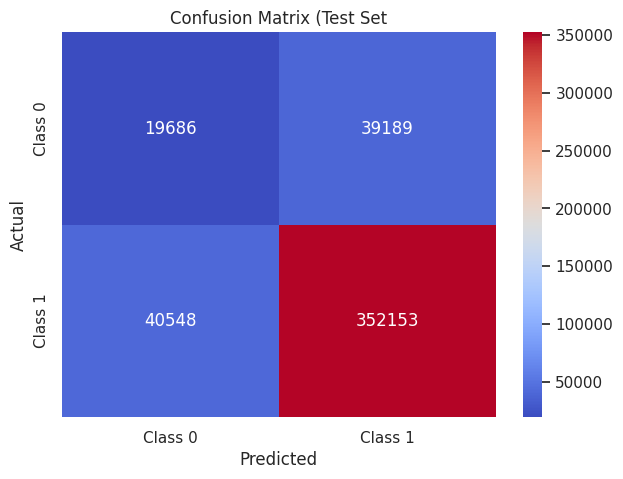

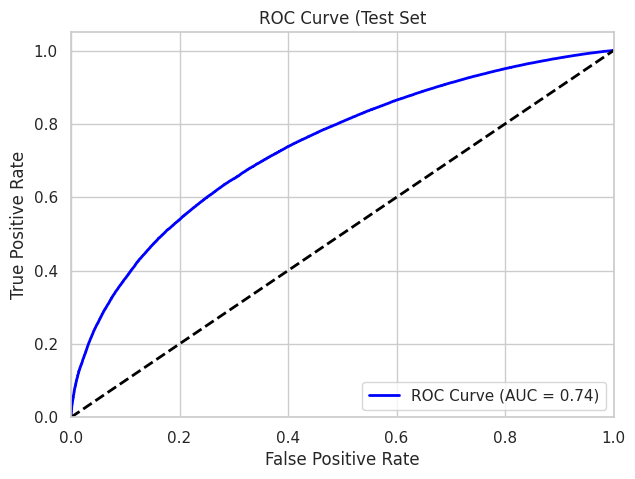

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.33      0.33      0.33     58875
     Class 1       0.90      0.90      0.90    392701

    accuracy                           0.82    451576
   macro avg       0.61      0.62      0.61    451576
weighted avg       0.83      0.82      0.82    451576



In [57]:
#Model Evaluation
evaluate_model(
    model=pipeline,
    model_name="XGBoost Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)


=== Evaluation Results for XGBoost Model===

Test Set Metrics:
Accuracy: 0.8207
Precision: 0.9009
Recall: 0.8919
F1 Score: 0.8964
ROC AUC: 0.7413


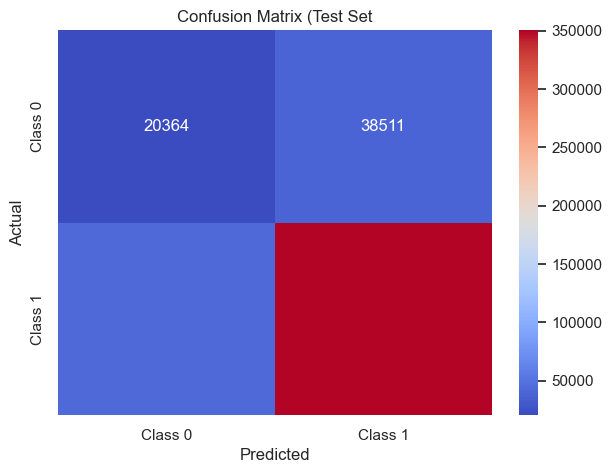

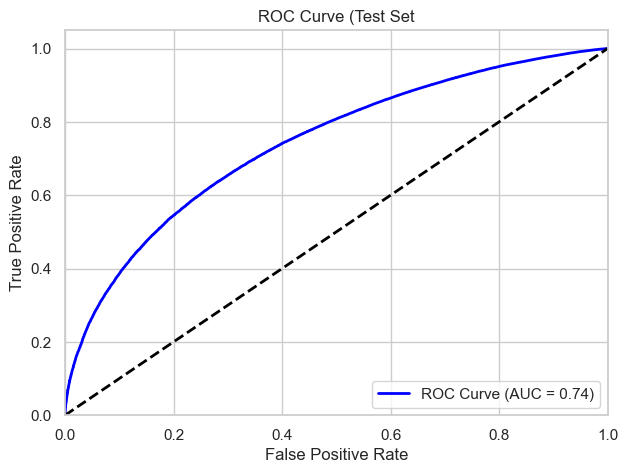

Classification Report (Test Set:
               precision    recall  f1-score   support

     Class 0       0.32      0.35      0.33     58875
     Class 1       0.90      0.89      0.90    392701

    accuracy                           0.82    451576
   macro avg       0.61      0.62      0.62    451576
weighted avg       0.83      0.82      0.82    451576



In [156]:
#Model Evaluation - after new feature engineering
evaluate_model(
    model=pipeline,
    model_name="XGBoost Model",
    train_combined=X_train_balanced,
    y_train=y_train_balanced,
    test_combined=X_test,
    y_test=y_test
)